## Adding COCO Data Using Custom Generator

In [17]:
import glob
import json
import os
import zipfile

import cv2
import gdown
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from luxonis_ml.data import LuxonisDataset, LuxonisLoader

In [18]:
# Delete dataset if exists

dataset_name = "coco_test"
if LuxonisDataset.exists(dataset_name):
    dataset = LuxonisDataset(dataset_name)
    dataset.delete_dataset()

### Download and extract data

In [19]:
url = "https://drive.google.com/uc?id=1XlvFK7aRmt8op6-hHkWVKIJQeDtOwoRT"
output_zip = "../data/COCO_people_subset.zip"
output_folder = "../data/"

if not os.path.exists(output_folder):
    os.mkdir(output_folder)
# Check if the data already exists
if not os.path.exists(output_zip) and not os.path.exists(
    os.path.join(output_folder, "COCO_people_subset")
):
    # Download the file
    gdown.download(url, output_zip, quiet=False)

    # Unzip the file
    with zipfile.ZipFile(output_zip, "r") as zip_ref:
        zip_ref.extractall(output_folder)
else:
    print("Data already exists. Exiting.")

Data already exists. Exiting.

### Convert from COCO people subset example

`LuxonisDataset` will expect a generator that yields data in the following format:
```
- file [str] : path to file on local disk or object storage
- class [str]: string specifying the class name or label name
- type [str] : the type of label or annotation
- value [Union[str, list, int, float, bool]]: the actual annotation value
    For here are the expected structures for `value`.
    The function will check to ensure `value` matches this for each annotation type

    value (classification) [bool] : Marks whether the class is present or not
        (e.g. True/False)
    value (box) [List[float]] : the normalized (0-1) x, y, w, and h of a bounding box
        (e.g. [0.5, 0.4, 0.1, 0.2])
    value (polyline) [List[List[float]]] : an ordered list of [x, y] polyline points
        (e.g. [[0.2, 0.3], [0.4, 0.5], ...])
    value (segmentation) [Tuple[int, int, List[int]]]: an RLE representation of (height, width, counts) based on the COCO convention
    value (keypoints) [List[List[float]]] : an ordered list of [x, y, visibility] keypoints for a keypoint skeleton instance
        (e.g. [[0.2, 0.3, 2], [0.4, 0.5, 2], ...])
    value (array) [str]: path to a numpy .npy file
```

In [26]:
def COCO_people_subset_generator():
    # find image paths and load COCO annotations
    img_dir = "../data/person_val2017_subset"
    annot_file = "../data/person_keypoints_val2017.json"
    # get paths to images sorted by number
    im_paths = glob.glob(os.path.join(img_dir, "*.jpg"))
    nums = np.array(
        [int(os.path.splitext(os.path.basename(path))[0]) for path in im_paths]
    )
    idxs = np.argsort(nums)
    im_paths = list(np.array(im_paths)[idxs])
    # load
    with open(annot_file) as file:
        data = json.load(file)
    imgs = data["images"]
    anns = data["annotations"]
    # Create dictionaries for quick lookups
    img_dict = {img["file_name"]: img for img in imgs}
    ann_dict = {}
    for ann in anns:
        img_id = ann["image_id"]
        if img_id not in ann_dict:
            ann_dict[img_id] = []
        ann_dict[img_id].append(ann)

    # Process each image and its annotations
    for i, path in tqdm(enumerate(im_paths)):
        # Find annotations matching the COCO image
        gran = os.path.basename(path)
        img = img_dict.get(gran, None)
        if img is None:
            continue
        img_id = img["id"]
        img_anns = ann_dict.get(img_id, [])

        # Load the image
        im = cv2.imread(path)
        height, width, _ = im.shape

        if len(img_anns):
            yield {
                "file": path,
                "annotation": {
                    "type": "classification",
                    "class": "person",
                },
            }

        for ann in img_anns:
            # COCO-specific conversion for segmentation
            seg = ann["segmentation"]
            if isinstance(seg, list):  # polyline format
                poly = []
                for s in seg:
                    poly_arr = np.array(s).reshape(-1, 2)
                    poly += [
                        (poly_arr[i, 0] / width, poly_arr[i, 1] / height)
                        for i in range(len(poly_arr))
                    ]
                yield {
                    "file": path,
                    "annotation": {
                        "type": "polyline",
                        "class": "person",
                        "points": poly,
                    },
                }

            else:  # RLE format
                yield {
                    "file": path,
                    "annotation": {
                        "type": "rle",
                        "class": "person",
                        "height": seg["size"][0],
                        "width": seg["size"][1],
                        "counts": seg["counts"],
                    },
                }

            # COCO-specific conversion for bounding boxes
            x, y, w, h = ann["bbox"]
            yield {
                "file": path,
                "annotation": {
                    "type": "boundingbox",
                    "instance_id": i,
                    "class": "person",
                    "x": x / width,
                    "y": y / height,
                    "w": w / width,
                    "h": h / height,
                },
            }

            # COCO-specific conversion for keypoints
            kps = np.array(ann["keypoints"]).reshape(-1, 3)
            keypoints = []
            for kp in kps:
                keypoints.append(
                    (float(kp[0] / width), float(kp[1] / height), int(kp[2]))
                )
            yield {
                "file": path,
                "annotation": {
                    "type": "keypoints",
                    "instance_id": i,
                    "class": "person",
                    "keypoints": keypoints,
                },
            }

In [27]:
dataset = LuxonisDataset(dataset_name)

annot_file = "../data/person_keypoints_val2017.json"
with open(annot_file) as file:
    data = json.load(file)

dataset.set_skeletons(
    {
        "person": {
            "labels": data["categories"][0]["keypoints"],
            "edges": (np.array(data["categories"][0]["skeleton"]) - 1).tolist(),
        }
    },
    task="keypoints",
)

dataset.add(COCO_people_subset_generator())

30it [00:00, 130.53it/s]

c:\Users\jerne\Desktop\luxoins-ml-speed\.venv\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets"
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

### Define Splits

In [22]:
# without providing manual splits, this will randomly split the data
dataset.make_splits()

### Test Loader

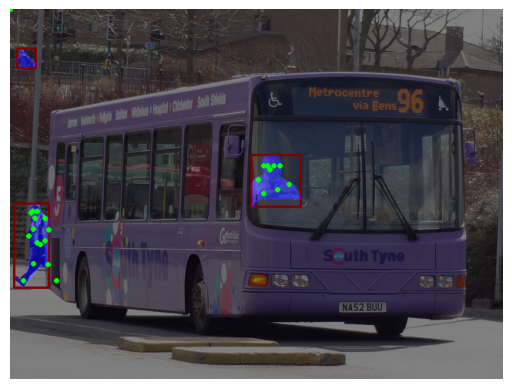

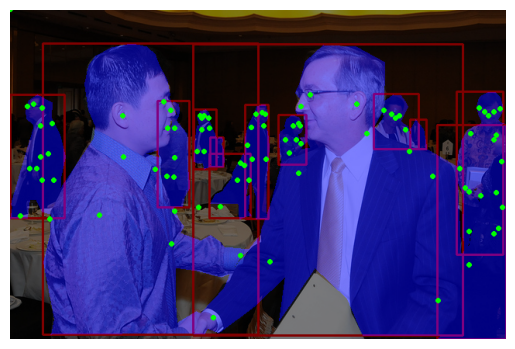

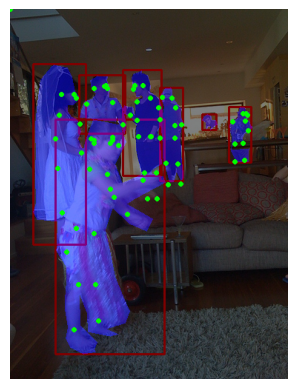

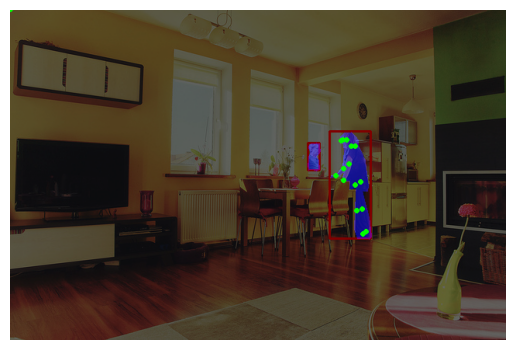

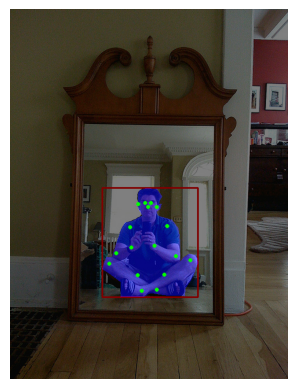

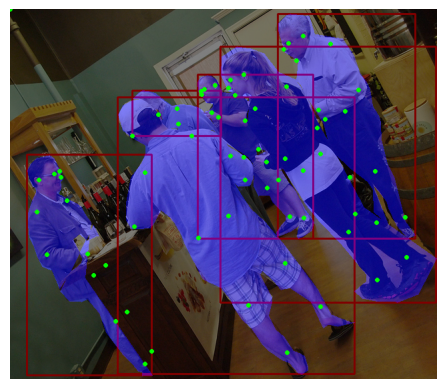

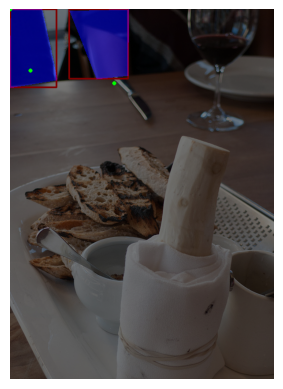

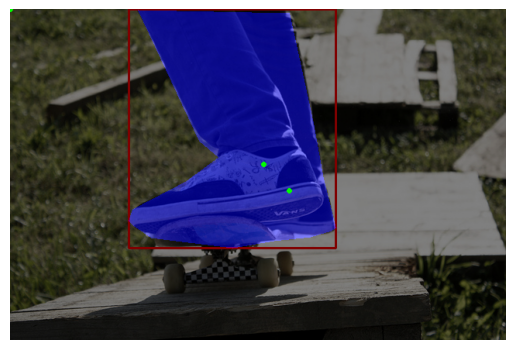

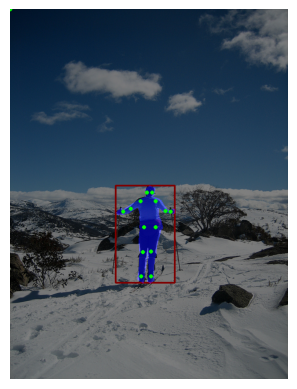

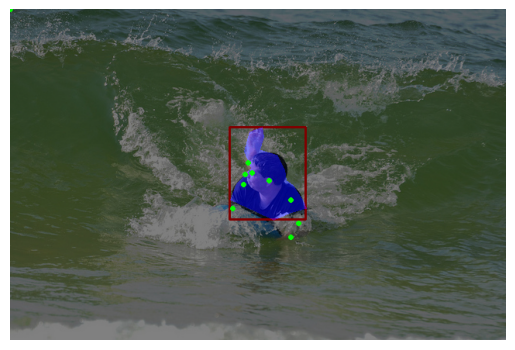

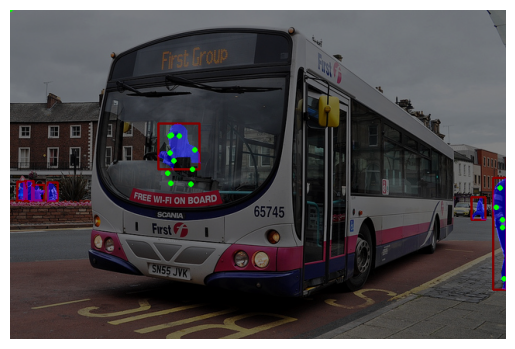

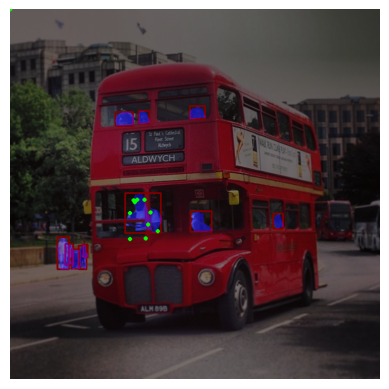

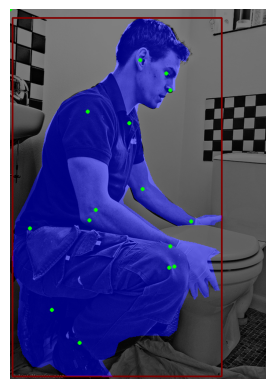

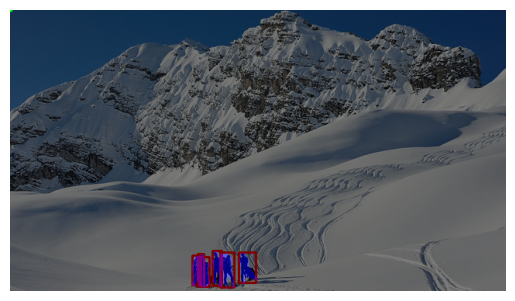

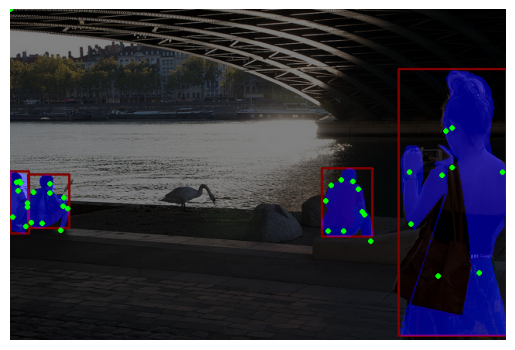

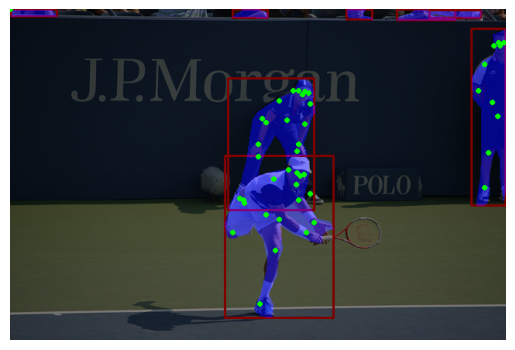

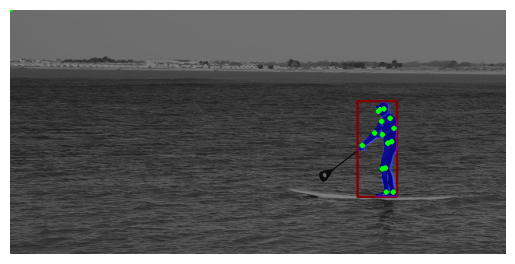

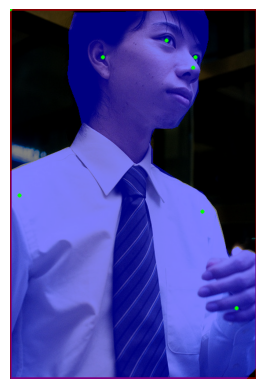

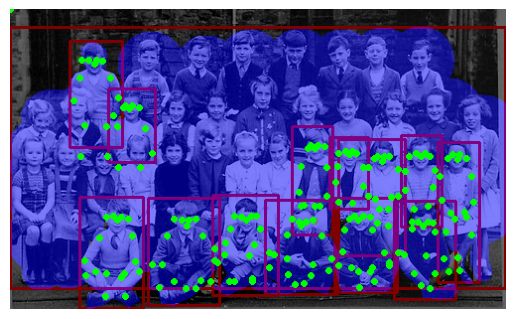

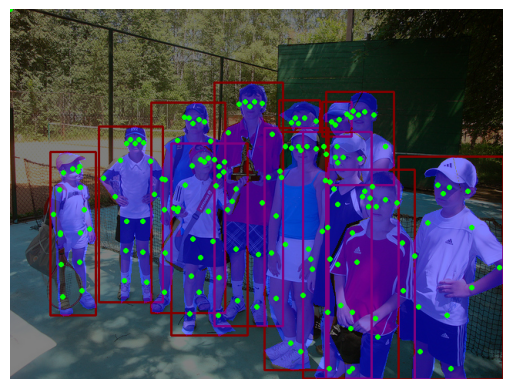

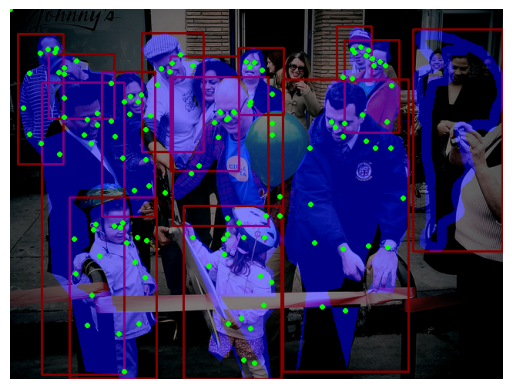

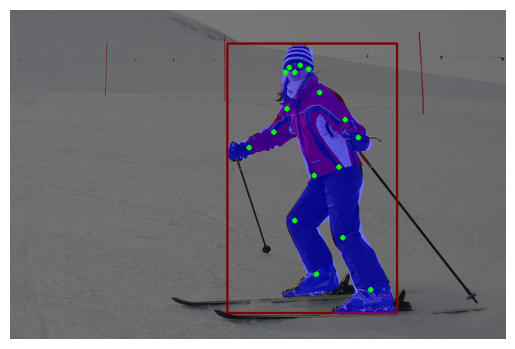

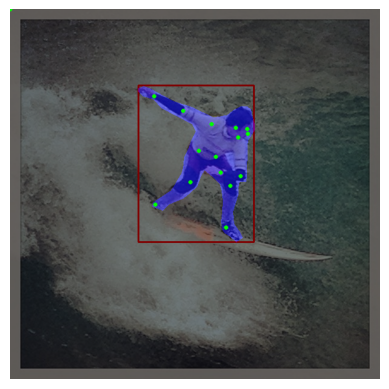

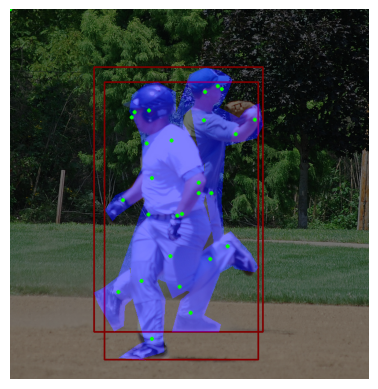

In [23]:
loader = LuxonisLoader(dataset, view="train")
for image, ann in loader:
    cls = ann["classification"][0]
    box = ann["boundingbox"][0]
    seg = ann["segmentation"][0]
    kps = ann["keypoints"][0]

    h, w, _ = image.shape
    for b in box:
        cv2.rectangle(
            image,
            (int(b[1] * w), int(b[2] * h)),
            (int(b[1] * w + b[3] * w), int(b[2] * h + b[4] * h)),
            (255, 0, 0),
            2,
        )
    mask_viz = np.zeros((h, w, 3)).astype(np.uint8)
    for mask in seg:
        mask_viz[mask == 1, 2] = 255
    image = cv2.addWeighted(image, 0.5, mask_viz, 0.5, 0)

    for kp in kps:
        kp = kp[1:].reshape(-1, 3)
        for k in kp:
            cv2.circle(image, (int(k[0] * w), int(k[1] * h)), 2, (0, 255, 0), 2)

    plt.imshow(image)
    plt.axis("off")  # Optional: Hide axis
    plt.show()